<a href="https://colab.research.google.com/github/lsh950919/Portfolio/blob/main/Post_COVID_19_Project_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [1]:
%cd /content/drive/My Drive/Colab Notebooks/Project 2 data

/content/drive/My Drive/Colab Notebooks/Project 2 data


In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/Project 2 data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
!pip install ipython.autotime
%load_ext autotime

  Using cached https://files.pythonhosted.org/packages/3f/58/a4a65efcce5c81a67b6893ade862736de355a3a718af5533d30c991831ce/ipython_autotime-0.2.0-py2.py3-none-any.whl
time: 193 µs


In [3]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
fm._rebuild()

plt.rc('axes', unicode_minus = False)



time: 2.48 s


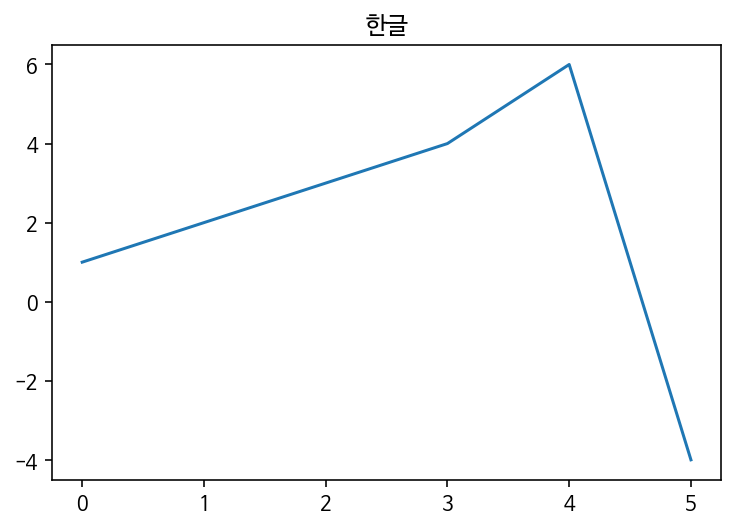

time: 240 ms


In [4]:
pd.Series([1, 2,3, 4, 6, -4]).plot(title="한글")

In [5]:
df = pd.read_csv('인구카드코로나.csv')

time: 357 ms


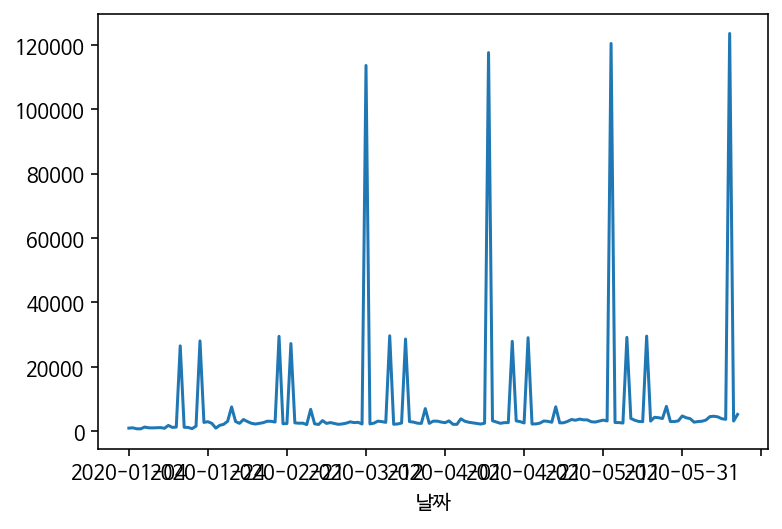

time: 259 ms


In [6]:
df[df['업종명'] == '가전제품'].groupby('날짜')['판매건수'].sum().plot()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474854 entries, 0 to 474853
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   날짜      474854 non-null  object
 1   업종명     474854 non-null  object
 2   시군구     474854 non-null  object
 3   판매건수    474854 non-null  int64 
 4   매출액     474854 non-null  int64 
 5   유동인구합   474854 non-null  int64 
 6   업계      474854 non-null  object
 7   확진자수    474854 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 29.0+ MB


In [ ]:
df.날짜 = pd.to_datetime(df.날짜, format = '%Y-%m-%d')

## 주말

주말의 여부에 따라 특정 업종의 판매건수가 크게 달라지는 경우가 있어 주말 열 추가

In [ ]:
df['주말'] = df.날짜.dt.dayofweek.apply(lambda x: 1 if x > 4 else 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474854 entries, 0 to 474853
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   날짜      474854 non-null  datetime64[ns]
 1   업종명     474854 non-null  object        
 2   시군구     474854 non-null  object        
 3   판매건수    474854 non-null  int64         
 4   매출액     474854 non-null  int64         
 5   유동인구합   474854 non-null  int64         
 6   업계      474854 non-null  object        
 7   확진자수    474854 non-null  int64         
 8   주말      474854 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 32.6+ MB


## 유사 업종 합치기

In [ ]:
# 원본 카드 데이터를 변경해주기
card_gu = pd.read_csv('card_gu.csv')

In [ ]:
card_gu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573906 entries, 0 to 573905
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   날짜      573906 non-null  int64 
 1   업종코드    573906 non-null  int64 
 2   업종명     573906 non-null  object
 3   시군구     573906 non-null  object
 4   판매건수    573906 non-null  int64 
 5   매출액     573906 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 26.3+ MB


In [ ]:
card_gu = card_gu.drop('업종코드', axis = 1)
card_gu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573906 entries, 0 to 573905
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   날짜      573906 non-null  int64 
 1   업종명     573906 non-null  object
 2   시군구     573906 non-null  object
 3   판매건수    573906 non-null  int64 
 4   매출액     573906 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 21.9+ MB


In [ ]:
# 변경할 데이터 카피
card_gu_changed = card_gu.copy()

비슷하다고 생각 되는 업종들이 다수 있어, 이 업종들을 그룹지어 이름을 변환했습니다

In [ ]:
# 함수 정의
from functools import reduce
def sum_industry(lst):
  # 각 업종명 데이터를 담을 리스트
  df_list = []
  # 제거할 업종명들을 잘라와 리스트에 담기
  for i in range(len(lst[0])):
    industry = card_gu_changed[card_gu_changed['업종명'] == lst[0][i]]
    df_list.append(industry)
    card_gu_changed.drop(card_gu_changed[card_gu_changed['업종명'] == lst[0][i]].index, axis = 0, inplace = True)
  # 잘라온 데이터프레임들 결합
  merged = reduce(lambda x, y: pd.merge(x, y, how = 'outer', copy = True), df_list).sort_values(by = '날짜')
  # 업종명들의 매출액과 판매건수 수합
  grouped_sum = merged.groupby(['날짜', '시군구'])[['판매건수', '매출액']].sum().reset_index()
  # 통틀어 지정할 업종명 지정
  grouped_sum['업종명'] = lst[-1]
  # 업종명들이 제거된 데이터프레임과 수합한 데이터프레임 결합
  returned = pd.concat([card_gu_changed, grouped_sum], copy = True)
  return returned

In [ ]:
changes = [[["교육테이프", "기타교육"], '기타교육'], [["유치원", "유아원"], "유아원"], [["컴퓨터학원", "기능교육", "기능학원"], "기능학원"], 
           [["부동산분양", "부동산중개/임대"], "부동산중개/임대"], 
           [["공무원연금매점", "구내매점", "스넥" , "편의점(국가기관등)", '구내매점(국가기관등)', "편의점"], "편의점"], 
           [["기타서적문구", "전문서적",  "서적출판(회원제형태)", "일반서적"], "일반서적"], 
           [["철제가구", "일반가구", '기타가구'], '가구'], [['조명기구', '인테리어'], '인테리어'],
           [["슈퍼마켓", "대형할인점"], "대형할인점"], [["주방용식기", "기타주방용구", "주방용구"], "주방용구"], 
           [["피아노대리점", "악기점"], "악기점"], [["전기차충전소", "주유소"], "주유소"], [["한방병원", "한의원"], "한의원"], 
           [["조산원", "산후조리원"], "산후조리원"], 
           [["건강진단", "기타의료기관및기타의료기기"], "기타의료기관및기타의료기기"], 
           [["병원", "의원"], "의원"], [["치과병원", "치과의원"], "치과의원"], [["종합레져타운", "레져업소(회원제형태)"], "레져업소"], 
           [["골프경기장", "골프연습장"], "골프연습장"], [["인터넷Mall", "인터넷종합Mall"], "인터넷종합Mall"],
           [["통신판매(생활서비스)", "통신판매(일반)", "통신판매2", "통신판매1"], '통신판매'], 
           [["택시회사", "택시"], "택시"], [["렌트카",  "기타교통수단"], "기타교통수단"], 
           [["국산신차직영부품/정비업소", "기타자동차서비스", "자동차서비스(회원제형태)", "자동차시트/타이어", "카인테리어", "자동차정비"], "자동차서비스"], 
           [["갈비전문점", "한정식", "일반한식"], "일반한식"], [["칵테일바", "단란주점", "유흥주점", "주점"], "주점"], 
           [["농축산가공품", "기타음료식품"], "기타음료식품"], 
           [["홍삼제품", "건강식품(회원제형태)", "인삼제품", "기타건강식"], "기타건강식"], [["CATV", "위성방송"], "위성방송"], 
           [["통신기기무이자할부", "통신/서비스", "통신서비스/비대상", "통신기기"],"통신기기"], 
           [['기타의류', '내의판매점', '단체복', '맞춤복점', '스포츠의류', '아동의류', '양품점', '와이셔츠/타이', '정장', '캐쥬얼의류'], '오프라인의류매장']]

In [ ]:
for item in changes:
  card_gu_changed = sum_industry(item)

In [ ]:
# 제대로 제거 되었는지 확인
card_gu_changed[card_gu_changed['업종명'].isin(changes[i][0][j] for i in range(len(changes)) for j in range(len(changes[i]) - 1))]['업종명'].unique()

array([], dtype=object)

In [ ]:
# 제대로 필터 됐는지 확인
card_gu_changed[card_gu_changed['업종명'].isin(changes[i][-1] for i in range(len(changes)))]['업종명'].unique()

array(['기타교육', '유아원', '기능학원', '부동산중개/임대', '편의점', '일반서적', '가구', '인테리어',
       '대형할인점', '주방용구', '악기점', '주유소', '한의원', '산후조리원', '기타의료기관및기타의료기기',
       '의원', '치과의원', '레져업소', '골프연습장', '인터넷종합Mall', '통신판매', '택시', '기타교통수단',
       '자동차서비스', '일반한식', '주점', '기타음료식품', '기타건강식', '위성방송', '통신기기',
       '오프라인의류매장'], dtype=object)

In [ ]:
card_gu_changed['업종명'].unique()

array(['특급호텔', '1급호텔', '기타숙박업', '항공사', '관광여행', '골프용품', '스포츠레져용품', '스크린골프',
       '헬스크럽', '당구장', '노래방', '기타레져업', '화랑', '화방표구점', '민예공예품', '수족관', '화원',
       '애완동물', '영화관', '티켓', '가전제품', '기타전기제품', '유류판매', '카메라', '사진관',
       '자사카드발행백화점', '농축수산가공품', 'CATV홈쇼핑', '인터넷P/G', '상품권', '상품권전문판매',
       '전자상거래상품권전문판매', '기타유통업', '옷감직물', '침구수예점', '기타직물', '가방', '시계',
       '귀금속', '악세사리', '제화점', '신발', '기념품점', '기타잡화', '출판인쇄물', '문구용품',
       '과학기자재', '완구점', '외국어학원', '예체능학원', '보습학원', '독서실', '컴퓨터', '전자(상우회)',
       '기타사무용품', '수입자동차', '이륜차판매', '자동차부품', '윤활유전문판매', '세차장', '주차장',
       '종합병원', '약국', '한약방', '동물병원', '이용원', '미용원', '피부미용실', '안경', '화장품',
       '미용재료', '의료용품', '사우나', '안마/스포츠마사지', '기타대인서비스', '일식회집', '중국음식',
       '서양음식', '위탁급식업', '제과점', '정육점', '주류판매점', '농축수산품', '미곡상', '보일러펌프샷시',
       '건축요업품', '페인트', '기타건축자재', '종합용역', '혼례서비스', '화물운송', '사무서비스',
       '법률회계서비스(개인)', '소프트웨어', '법률회계서비스(법인)', '조세서비스', '조세서비스(특약)',
       '기타용역서비스', '가정용품수리', '사무통신기기수리', '세탁소', '학원(회원제형태)', '기타회원제형태업소4',
       

In [ ]:
card_gu_changed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461463 entries, 0 to 3874
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   날짜      461463 non-null  int64 
 1   업종명     461463 non-null  object
 2   시군구     461463 non-null  object
 3   판매건수    461463 non-null  int64 
 4   매출액     461463 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 21.1+ MB


비록 전처리를 이미 진행 했었으나, 특정 업종명 변경 후 전처리를 다시 해줘야 했습니다

그리고 이번 프로젝트에서는 B2C 업종만을 다루기에 C2C 업종이라 판단되는 업종명들을 제거했습니다

In [ ]:
# 전처리 코드 재실행
pop_sum = pd.read_csv('pop_sum.csv')
df = card_gu_changed.merge(pop_sum, how = 'left')
df.날짜 = pd.to_datetime(df.날짜, format = '%Y%m%d')

# 제거할 업종명
delete = ['의료용품', '제약회사', '초중고교육기관', '기타운송', '화물운송', '사무통신기기수리', '사무기기', '중고자동차위탁판매', '자동차부품', 
          '위탁급식업', '미곡상', '옷감직물', '기타직물', '농축수산품', '기타건축자재', '기계공구', '비영리', '사무서비스', '기타대인서비스', '기타사무용품',
          '출판인쇄물', '기타유통업', '종합용역', '조세서비스(특약)', '조세서비스', '법률회계서비스(법인)', '법률회계서비스(개인)', '전자(상우회)',
          '기타용역서비스', '보일러펌프샷시', '과학기자재', '비씨카드정산용(할인)', '비영리/비대상', '보관창고업', '냉열기기', '기타광학품', '유리',
          '사무서비스(회원제형태)', '사업자미등록개인', '기타비영리유통', '중장비수리', '기타농업관련', '자체물품대금', '비료/농약/사료/종자', 
          '농기계', '건축요업품', '미용재료', '페인트', '윤활유전문판매', '기타연료', '유류판매']

# 업종명 제거
df_del = df[~df['업종명'].isin(delete)].copy()


In [ ]:
df_del.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357847 entries, 0 to 461462
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   날짜      357847 non-null  datetime64[ns]
 1   업종명     357847 non-null  object        
 2   시군구     357847 non-null  object        
 3   판매건수    357847 non-null  int64         
 4   매출액     357847 non-null  int64         
 5   유동인구    357847 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 19.1+ MB


In [ ]:
df_del['업종명'].unique()

array(['특급호텔', '1급호텔', '기타숙박업', '항공사', '관광여행', '골프용품', '스포츠레져용품', '스크린골프',
       '헬스크럽', '당구장', '노래방', '기타레져업', '화랑', '화방표구점', '민예공예품', '수족관', '화원',
       '애완동물', '영화관', '티켓', '가전제품', '기타전기제품', '카메라', '사진관', '자사카드발행백화점',
       '농축수산가공품', 'CATV홈쇼핑', '인터넷P/G', '상품권', '상품권전문판매', '전자상거래상품권전문판매',
       '침구수예점', '가방', '시계', '귀금속', '악세사리', '제화점', '신발', '기념품점', '기타잡화',
       '문구용품', '완구점', '외국어학원', '예체능학원', '보습학원', '독서실', '컴퓨터', '수입자동차',
       '이륜차판매', '세차장', '주차장', '종합병원', '약국', '한약방', '동물병원', '이용원', '미용원',
       '피부미용실', '안경', '화장품', '사우나', '안마/스포츠마사지', '일식회집', '중국음식', '서양음식',
       '제과점', '정육점', '주류판매점', '혼례서비스', '소프트웨어', '가정용품수리', '세탁소',
       '학원(회원제형태)', '기타회원제형태업소4', '기타전문점', '2급호텔', '문화취미기타', '성인용품점',
       '면세점', 'PG상품권', '손해보험', '기타수리서비스', '생명보험', '신변잡화수리', '이동통신요금',
       '장례서비스', '콘도', '고속버스', '철도', '여객선', '카지노', '스키장', '볼링장', '테니스장',
       '수영장', '골동품점', '정수기', 'LPG', '일반백화점', '연쇄점', '전자상거래상품권', '혼수전문점',
       '정기간행물', '학습지교육', '대학등록금', '유학원', '국산신차', '중고자동차', '견인서비스'

업종명들을 대표적인 B2C 업계들로 분류 했습니다

In [ ]:
# 업종명 분류 함수 정의
def sort_induty(x):
  a = ''
  if x in ['약국', '치과의원', '한의원', '의원', '병원', '종합병원', '기타의료기관및기타의료기기', '산후조리원', '한방병원', '조산원', '안경', '의료용품', 
           '치과병원', '건강진단', '제약회사']:
    a = '메디컬'
  elif x in ['기타교육', '보습학원', '예체능학원', '유아원', '학원(회원제형태)', '독서실', '외국어학원', '기능학원', '학습지교육', '초중고교육기관', 
             '유학원', '유치원', '컴퓨터학원', '교육테이프', '대학등록금']:
    a = '교육'
  elif x in ['미용원', '이용원', '화장품', '오프라인의류매장', '제화점', '악세사리', '가방', '귀금속', '기타잡화', '시계', '신발']:
    a = '패션&뷰티'
  elif x in ['인터넷Mall', '인터넷종합Mall', '인터넷P/G', 'CATV홈쇼핑', '통신판매', 'PG상품권', '전자상거래상품권']:
    a = '비대면쇼핑'
  elif x in ['고속버스', '택시회사', '택시', '철도', '항공사', '여객선', '렌트카', '기타운송', '기타교통수단', '화물운송']:
    a = '이동수단'
  elif x in ['CATV', '통신기기', '통신기기무이자할부', '카메라', '통신서비스', '통신서비스/비대상', '이동통신요금', '정보서비스', '컴퓨터', 
             '위성방송', '사무통신기기수리', '사무기기', '소프트웨어']:
    a = 'IT'
  elif x in ['중고자동차위탁판매', '중고자동차', '국산신차', '자동차부품', '자동차시트/타이어', '수입자동차', '국산신차직영부품/정비업소', 
             '국산신차직영부품/정비업소', '자동차서비스', '카인테리어', '기타자동차서비스', '이륜차판매', '자동차정비']:
    a = '자동차'
  elif x in ['서양음식', '중국음식', '일식회집', '일반한식', '한정식', '기타건강식', '위탁급식업', '미곡상', '인삼제품', '건강식품(회원제형태)', '갈비전문점',
             '주점', '단란주점', '기타음료식품', '유흥주점', '칵테일바', '농축수산가공품', '홍삼제품']:
    a = 'F&B'
  elif x in ['1급호텔', '기타숙박업', '2급호텔', '특급호텔', '콘도']:
    a = '숙박'
  elif x in ['헬스크럽']:
    a = '피트니스'
  elif x in ['기타레져', '스포츠레져용품', '레져업소', '스크린골프', '골프연습장', '골프용품', '문화취미기타', '테니스장', '볼링장', '수영장',
             '영화관', '스키장', '레져용품수리', '종합레져타운', '카지노', '수족관', '티켓', '골프경기장', '기타레져업', '노래방', '당구장',
             '관광여행']:
    a = '문화&오락'
  elif x in ['부동산중개/임대', '부동산분양', '손해보험', '생명보험', '기타보험', 'P2P송금']:
    a = '금융&부동산'
  elif x in ['농축수산품', '기타건축자재', '기계공구', '화원', '비영리', '사무서비스', '기타대인서비스', '기타사무용품', '출판인쇄물', '기타유통업',
             '종합용역', '조세서비스(특약)', '조세서비스', '기타전문점', '기타회원제형태업소4', '법률회계서비스(법인)', '회원제형태업소4', 
             '법률회계서비스(법인)', '혼례서비스', '법률회계서비스(개인)', '전자(상우회)', '기타용역서비스', '보일러펌프샷시', '과학기자재', '기념품점',
             '성인용품점', '비씨카드정산용(할인)', '기타수리서비스', '신변잡화수리', '비영리/비대상', '장례서비스', '기타회원제형태업소1', '기타회원제형태업소2',
             '기타회원제형태업소3', '보관창고업', '냉열기기', '기타광학품', '유리', '공공요금/대상', '사무서비스(회원제형태)', '견인서비스', '사업자미등록개인',
             '기타비영리유통', '중장비수리', '외국인전용가맹점', '기타회원제형태업소5', '골동품점', '혼수전문점', '기타농업관련', '자체물품대금', '총포류판매',
             '비료/농약/사료/종자', '공공요금', '농기계', '건축요업품', '미용재료', '페인트', '윤활유전문판매', '기타연료', '유류판매']:
    a = '기타'
  else:
    a = '라이프스타일'
  return a

In [ ]:
# 업계 분류
df_del['업계'] = df.업종명.apply(sort_induty)
df_del.업계.unique()

array(['숙박', '이동수단', '문화&오락', '피트니스', '라이프스타일', '기타', 'IT', 'F&B',
       '비대면쇼핑', '패션&뷰티', '교육', '자동차', '메디컬', '금융&부동산'], dtype=object)

In [ ]:
df_del

,날짜,업종명,시군구,판매건수,매출액,유동인구,업계
0,2020-01-04,특급호텔,강남구,549,146315331,4268654,숙박
1,2020-01-04,특급호텔,중구,928,239811377,1669677,숙박
2,2020-01-04,1급호텔,중구,38,6941145,1669677,숙박
3,2020-01-04,기타숙박업,강남구,444,57200876,4268654,숙박
4,2020-01-04,기타숙박업,강동구,180,7928000,2425402,숙박
...,...,...,...,...,...,...,...
461458,2020-06-14,오프라인의류매장,용산구,548,59431500,1848525,패션&뷰티
461459,2020-06-14,오프라인의류매장,은평구,684,36445600,1436435,패션&뷰티
461460,2020-06-14,오프라인의류매장,종로구,1184,79018656,1269669,패션&뷰티
461461,2020-06-14,오프라인의류매장,중구,7300,447805275,1166980,패션&뷰티


In [ ]:
# 코로나 결합
covid = pd.read_csv('monthly_covid19_seoul_long_0806.csv')
covid.날짜 = pd.to_datetime(covid.날짜)
card_covid = df_del.merge(covid, how = 'left')
# 확진자수가 결측치인 값들 채우고 정수로 변환
card_covid.확진자수 = card_covid.확진자수.fillna(0).astype(int)

In [ ]:
card_covid.to_csv('인구카드코로나.csv', index = False)

In [ ]:
df = pd.read_csv('인구카드코로나.csv')

In [ ]:
df.head()

,날짜,업종명,시군구,판매건수,매출액,유동인구,업계,확진자수
0,2020-01-04,특급호텔,강남구,549,146315331,4268654,숙박,0
1,2020-01-04,특급호텔,중구,928,239811377,1669677,숙박,0
2,2020-01-04,1급호텔,중구,38,6941145,1669677,숙박,0
3,2020-01-04,기타숙박업,강남구,444,57200876,4268654,숙박,0
4,2020-01-04,기타숙박업,강동구,180,7928000,2425402,숙박,0


In [ ]:
df['업종명'].unique()

array(['특급호텔', '1급호텔', '기타숙박업', '항공사', '관광여행', '골프용품', '스포츠레져용품', '스크린골프',
       '헬스크럽', '당구장', '노래방', '기타레져업', '화랑', '화방표구점', '민예공예품', '수족관', '화원',
       '애완동물', '영화관', '티켓', '가전제품', '기타전기제품', '카메라', '사진관', '자사카드발행백화점',
       '농축수산가공품', 'CATV홈쇼핑', '인터넷P/G', '상품권', '상품권전문판매', '전자상거래상품권전문판매',
       '침구수예점', '가방', '시계', '귀금속', '악세사리', '제화점', '신발', '기념품점', '기타잡화',
       '문구용품', '완구점', '외국어학원', '예체능학원', '보습학원', '독서실', '컴퓨터', '수입자동차',
       '이륜차판매', '세차장', '주차장', '종합병원', '약국', '한약방', '동물병원', '이용원', '미용원',
       '피부미용실', '안경', '화장품', '사우나', '안마/스포츠마사지', '일식회집', '중국음식', '서양음식',
       '제과점', '정육점', '주류판매점', '혼례서비스', '소프트웨어', '가정용품수리', '세탁소',
       '학원(회원제형태)', '기타회원제형태업소4', '기타전문점', '2급호텔', '문화취미기타', '성인용품점',
       '면세점', 'PG상품권', '손해보험', '기타수리서비스', '생명보험', '신변잡화수리', '이동통신요금',
       '장례서비스', '콘도', '고속버스', '철도', '여객선', '카지노', '스키장', '볼링장', '테니스장',
       '수영장', '골동품점', '정수기', 'LPG', '일반백화점', '연쇄점', '전자상거래상품권', '혼수전문점',
       '정기간행물', '학습지교육', '대학등록금', '유학원', '국산신차', '중고자동차', '견인서비스'

# 모델 피처 엔지니어링

In [ ]:
df = pd.read_csv('인구카드코로나.csv')
df['날짜'] = pd.to_datetime(df['날짜'])

time: 398 ms


In [ ]:
df['업종명'].nunique()

153

time: 31.5 ms


In [ ]:
df.shape

(357847, 8)

time: 7.07 ms


In [ ]:
# 판매건수가 적은 업종 보기
df_noetc = df[(df['업계'] != '기타')]
df_noetc['월'] = df_noetc['날짜'].dt.month
df1 = df_noetc.groupby(['월', '업종명'])['판매건수'].sum().sort_values().reset_index()
df1.groupby('업종명')['판매건수'].sum().sort_values().head(10)

업종명
카지노           0
P2P송금         3
콘도          134
유학원        1014
중고자동차      1615
테니스장       3795
산후조리원      4597
레져용품수리     5066
대학등록금      5134
수영장       11528
Name: 판매건수, dtype: int64

time: 118 ms


카지노, P2P송금, 콘도는 판매 데이터가 많지 않아 제거했습니다

In [ ]:
df = df[(df['업계'] != '기타') & (~df['업종명'].isin(['카지노', 'P2P송금', '콘도']))]
df.shape

(324041, 8)

time: 65.5 ms


In [ ]:
df['날짜'] = pd.to_datetime(df['날짜'])

df['요일'] = df.날짜.dt.dayofweek

time: 95.7 ms


서울 코로나 집단 감염사태 발생일자부터 네이버 데이터랩 기준 사태에 대한 검색횟수가 높았던 일자가 소비패턴에 영향을 줄 것이라 생각되어, 이슈 컬럼으로 추가 했습니다

2020년 3월 10일 ~ 3월 13일: 코리아빌딩

5월 7일 ~ 5월 20일: 이태원

5월 25일 ~ 5월 29일: 쿠팡물류센테

6월 4일 ~ 6월 14일: 리치웨이


예시: https://bit.ly/2R6dKu0

In [ ]:
dates = [pd.date_range('20200310', '20200313'), pd.date_range('20200507', '20200520'), 
         pd.date_range('20200525', '20200529'), pd.date_range('20200604', '20200614')]
datelist = []
for range in dates:
  for date in range:
    datelist.append(date)

df['이슈'] = df['날짜'].map(lambda x: 1 if x in datelist else 0)

time: 2.13 s


In [ ]:
df.head()

,날짜,업종명,시군구,판매건수,매출액,유동인구,업계,확진자수,요일,이슈
0,2020-01-04,특급호텔,강남구,549,146315331,4268654,숙박,0,5,0
1,2020-01-04,특급호텔,중구,928,239811377,1669677,숙박,0,5,0
2,2020-01-04,1급호텔,중구,38,6941145,1669677,숙박,0,5,0
3,2020-01-04,기타숙박업,강남구,444,57200876,4268654,숙박,0,5,0
4,2020-01-04,기타숙박업,강동구,180,7928000,2425402,숙박,0,5,0


time: 30.3 ms


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324041 entries, 0 to 357846
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   날짜      324041 non-null  datetime64[ns]
 1   업종명     324041 non-null  object        
 2   시군구     324041 non-null  object        
 3   판매건수    324041 non-null  int64         
 4   매출액     324041 non-null  int64         
 5   유동인구    324041 non-null  int64         
 6   업계      324041 non-null  object        
 7   확진자수    324041 non-null  int64         
 8   요일      324041 non-null  int64         
 9   이슈      324041 non-null  int64         
 10  시군구번호   324041 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 29.7+ MB
time: 95.1 ms


# 모델링

## ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error

time: 392 ms


훈련셋을 2020년 1월 4일부터 5월 14일까지, 검증셋을 5월 15일부터 6월 14일까지로 잡아 진행했습니다

In [ ]:
train = df[df['날짜'].isin(pd.date_range('20200104', '20200514'))]
test = df[~df['날짜'].isin(pd.date_range('20200104', '20200514'))]

time: 33.8 ms


In [ ]:
train_golf = train[train['업종명'] == '스크린골프'].groupby('날짜')['판매건수'].sum()
test_golf = test[test['업종명'] == '스크린골프'].groupby('날짜')['판매건수'].sum()
test_golf

날짜
2020-05-15    1142
2020-05-16    1580
2020-05-17    1753
2020-05-18    1613
2020-05-19    1169
2020-05-20    1362
2020-05-21    1238
2020-05-22    1267
2020-05-23    1316
2020-05-24    1691
2020-05-25    1729
2020-05-26    1139
2020-05-27    1209
2020-05-28    1261
2020-05-29    1223
2020-05-30    1301
2020-05-31    1647
2020-06-01    1580
2020-06-02    1127
2020-06-03    1235
2020-06-04    1324
2020-06-05    1224
2020-06-06    1345
2020-06-07    1669
2020-06-08    1651
2020-06-09    1138
2020-06-10    1171
2020-06-11    1202
2020-06-12    1254
2020-06-13    1407
2020-06-14    1724
Name: 판매건수, dtype: int64

time: 31.7 ms


ARIMA 모델 사용을 위한 자기상관성 (AutoRegressive), 정상성 (Integrated), 이동평균 (Moving Average)를 찾기 위한 ACF, PACF, 그리고 Augmented Dickey-Fuller Test를 적용해 보았습니다

(-4.210841319718128,
 0.0006316040697216705,
 13,
 110,
 {'1%': -3.4912451337340342,
  '10%': -2.5809876033057852,
  '5%': -2.8881954545454547},
 1505.1521607568204)

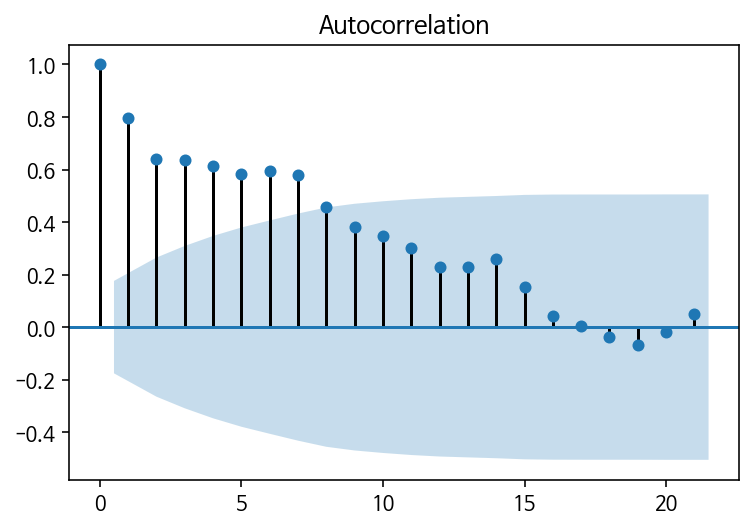

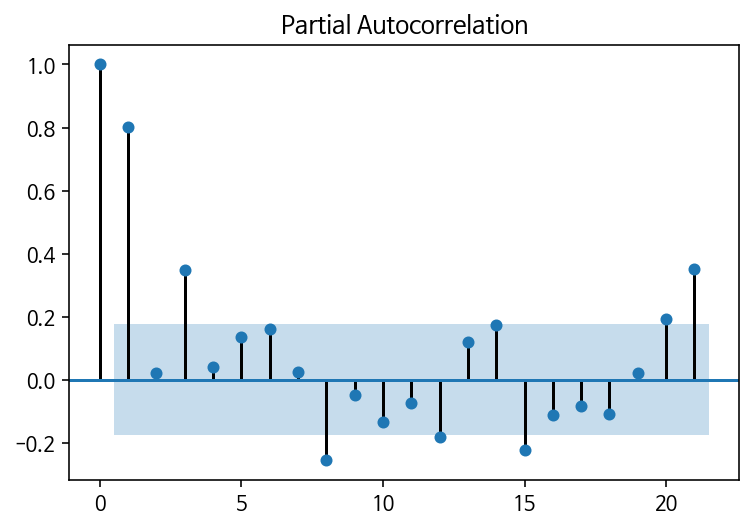

time: 492 ms


In [ ]:
# acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_golf)
plot_pacf(train_golf)

# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_golf)
result
# adfuller((train_golf - train_golf.shift(20)).dropna())
# d = 1

In [ ]:
model = ARIMA(train_golf, order = (7, 0, 7))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
output = model_fit.forecast(steps = 31) # 예측값
np.sqrt(mean_squared_error(te))

(array([1283.12789773, 1380.85742595, 1586.71592968, 1479.00207314,
        1281.4997071 , 1325.5802625 , 1405.74447692, 1422.62425377,
        1467.09866373, 1512.56537001, 1457.89779328, 1396.47037297,
        1432.33735786, 1485.372781  , 1500.50150041, 1512.90224256,
        1520.72022551, 1501.49719144, 1491.57542065, 1518.94267394,
        1548.548934  , 1557.48608373, 1561.27039919, 1564.88263117,
        1564.15550382, 1570.68438034, 1589.73126824, 1606.27029633,
        1612.66724516, 1616.81805111, 1622.7992475 ]),
 array([219.91351908, 262.8139054 , 266.53930936, 273.54659082,
        283.91472438, 294.02497214, 310.80829863, 344.35769049,
        363.24461767, 369.9114214 , 378.41819956, 390.57408337,
        403.18032586, 417.67467302, 433.68552414, 445.14379733,
        453.11745473, 462.3526762 , 473.55184274, 484.85098362,
        496.0727162 , 506.88512213, 516.11611912, 524.46297246,
        533.53846437, 543.36206709, 553.00374398, 562.25096399,
        571.0991415 ,

time: 1.27 s


### ARIMA 그리드서치
130개 업종에 대해 위 과정을 반복하는 것이 무리였기에, 대부분의 업종에 대한 주기가 1일~7일인것을 확인한 후 그리드서치 함수를 만들어 RMSE를 최소화하는 하이퍼 파라미터를 구했습니다

In [ ]:
# 각 업종별 최적 hyperparameter와 RMSE 계산 함수
import itertools
def gridARIMA(train_series, test_series): # 특정 업종명의 날짜별로 수합 된 판매건수의 훈련 & 검증셋을 각각 받음
  # 실험용 pdq (무시)
  # p = q = d = range(0, 2)
  # 실제 pdq 값: p와 q는 0-7, d는 0-1
  p = q = range(0, 8)
  d = range(0, 2)
  
  # 최적의 hyperparameter와 RMSE를 계산 후 넣을 dictionary
  rmse = {}

  # pdq의 모든 조합 만들기
  pdq = list(itertools.product(p, d, q))

  # trend에 들어갈 값
  trend = ['c', 'nc']

  train_series = train_series.astype(float)

  for param in pdq: # 각 pdq 조합별
    for item in trend: # 각 trend값 마다
      try:
        # 모델 구축
        model = ARIMA(train_series, order = param)
        model_fit = model.fit(trend = item, full_output = True, disp = 1)
        output = model_fit.forecast(steps = 31) # 예측값

        # 검증셋에 빈 날짜가 있을경우 RMSE 계산을 할 수 없으니, 예측값으로 채운 후 날짜로 정렬
        if len(pd.date_range('20200515', '20200614')[~pd.date_range('20200515', '20200614').isin(test_series.index)]):
          for date in pd.date_range('20200515', '20200614')[~pd.date_range('20200515', '20200614').isin(test_series.index)]:
            test_series.loc[date] = output[0][pd.date_range('20200515', '20200614').get_loc(date)]
        test_series = test_series.sort_index()
        
        # RMSE 계산 (key는 order와 trend에 들어가는 값 둘 다 가져오기 위해 같은 문자열에 넣고 추후 split으로 각각 구함)
        rmse[f'{param}|{item}'] = np.sqrt(mean_squared_error(test_series, output[0]))
      
      # 에러가 나면 멈추지 않고 다음 순서로 넘어감
      except: 
        continue
  # RMSE가 제일 낮은 조합 찾기
  key = min(rmse, key = rmse.get)
  # order와 trend hyperparameter로 나누기
  key_split = key.split('|')
  # order이 문자열로 되어있어 모델에 넣을 수 없으니, 넣을 수 있는 형식으로 변환
  key_split[0] = eval(key_split[0])
  # 업종명의 최적 hyperparameter (key_split)과 그 조합의 RMSE값을 리스트에 담아 반환
  return [key_split, rmse[key]]

time: 30.1 ms


In [ ]:
gridARIMA(train_golf, test_golf)

[[(6, 1, 7), 'nc'], 106.41318400116967]

time: 3min 24s


In [ ]:
# 통신판매
train_tel = train[train['업종명'] == '통신판매'].groupby('날짜')['판매건수'].sum()
test_tel = test[test['업종명'] == '통신판매'].groupby('날짜')['판매건수'].sum()

gridARIMA(train_tel, test_tel)

[[(7, 0, 3), 'c'], 21391.286955353356]

time: 1min 27s


In [ ]:
# 전자상거래상품권전문판매
train_coup = train[train['업종명'] == '전자상거래상품권전문판매'].groupby('날짜')['판매건수'].sum()
test_coup = test[test['업종명'] == '전자상거래상품권전문판매'].groupby('날짜')['판매건수'].sum()

gridARIMA(train_coup, test_coup)

[[(3, 0, 6), 'nc'], 488.44556040511924]

주기가 15일이나 30일인 업종의 경우 모델을 한번 실행할때도 시간이 오래 걸려 주기가 7일 내에 있는 업종들에 대해 그리드서치 함수를 적용해 예측값과 RMSE를 수합하고, 나머지 업종들은 따로 작업했습니다

In [ ]:
# 30일주기 제외 모든 업종명의 예측값과 RMSE 담기
def ARIMA_by_ind(df): # 전체 데이터 받음
  # 제외할 업종명
  day30 = ['생명보험', '소프트웨어', '가전제품', '전자상거래상품권전문판매', '정수기', '정기간행물', 
           '대형할인점', '통신기기', '위성방송', '통신판매', '전자상거래상품권', '학습지교육']
  
  # 결과를 담을 dictionary
  pred = {}
  
  # 모든 업종명
  names = df['업종명'].unique()
  
  # 훈련 & 검증셋 날짜기준 분할
  train = df[~df['날짜'].isin(pd.date_range('20200515', '20200614'))]
  test = df[df['날짜'].isin(pd.date_range('20200515', '20200614'))]
  
  for name in names: # 각 업종명별
    if name not in day30: # 제외하는 목록에 있지 않다면
      # 업종명의 날짜별 판매건수를 훈련 & 검증셋 내에서 수합
      train_ind = train[train['업종명'] == name].groupby('날짜')['판매건수'].sum()
      test_ind = test[test['업종명'] == name].groupby('날짜')['판매건수'].sum()
      
      # 최적의 hyperparameter와 
      best_param = gridARIMA(train_ind, test_ind)

      # 모델링
      model = ARIMA(train_ind, order = best_param[0][0])
      model_fit = model.fit(trend = best_param[0][1], full_output = True, disp = 1)
      
      # 예측값
      output = model_fit.forecast(steps = 31)
      
      # 결과를 담을 딕셔너리 안에 key를 업종명, value를 예측값과 RMSE가 담긴 리스트로 지정
      pred[name] = [output[0], best_param[1]]
  # 모든 업종명 계산 후 반환
  return pred

In [ ]:
ARIMA_by_ind(b)

In [ ]:
x = ARIMA_by_ind(b)

np.save('result08.npy', x)

In [ ]:
result08 = np.load('result08.npy', allow_pickle = True)
result08 = result08[()]
result30 = np.load('result30.npy', allow_pickle = True)
result30 = result30[()]

time: 760 ms


In [ ]:
print(len(result08), len(result30))
print(result08.keys())
result30.keys()

121 9
dict_keys(['특급호텔', '1급호텔', '기타숙박업', '항공사', '관광여행', '골프용품', '스포츠레져용품', '스크린골프', '헬스크럽', '당구장', '노래방', '기타레져업', '화랑', '화방표구점', '민예공예품', '수족관', '애완동물', '영화관', '티켓', '기타전기제품', '카메라', '사진관', '자사카드발행백화점', '농축수산가공품', 'CATV홈쇼핑', '인터넷P/G', '상품권', '상품권전문판매', '전자상거래상품권전문판매', '침구수예점', '가방', '시계', '귀금속', '악세사리', '제화점', '신발', '기타잡화', '문구용품', '완구점', '외국어학원', '예체능학원', '보습학원', '독서실', '컴퓨터', '수입자동차', '이륜차판매', '세차장', '주차장', '종합병원', '약국', '한약방', '동물병원', '이용원', '미용원', '피부미용실', '안경', '화장품', '사우나', '안마/스포츠마사지', '일식회집', '중국음식', '서양음식', '제과점', '정육점', '주류판매점', '가정용품수리', '세탁소', '학원(회원제형태)', '2급호텔', '문화취미기타', '면세점', 'PG상품권', '손해보험', '이동통신요금', '고속버스', '철도', '여객선', '스키장', '볼링장', '테니스장', '수영장', 'LPG', '일반백화점', '연쇄점', '대학등록금', '유학원', '국산신차', '중고자동차', '기타보험', '정보서비스', '통신서비스', '레져용품수리', '기타교육', '유아원', '기능학원', '부동산중개/임대', '편의점', '일반서적', '가구', '인테리어', '주방용구', '악기점', '주유소', '한의원', '산후조리원', '기타의료기관및기타의료기기', '의원', '치과의원', '레져업소', '골프연습장', '인터넷종합Mall', '통신판매', '택시', '기타교통수단', '자동차서비스', '일반한식', '주점', '기타음료식품', '기타건강식',

dict_keys(['가전제품', '정수기', '대형할인점', '정기간행물', '생명보험', '소프트웨어', '전자상거래상품권', '위성방송', '학습지교육'])

In [ ]:
result = {**result08, **result30}

time: 970 µs


In [ ]:
result

{'1급호텔': [array([423.29828126, 333.58069189, 137.68566153, 225.28442192,
         497.46271435, 519.61407905, 399.91059936, 387.02541444,
         296.97265789, 132.62021449, 233.66518066, 486.58635897,
         504.30296796, 392.7370087 , 369.32184151, 278.03979948,
         140.36288643, 250.45840838, 483.86847038, 495.95814373,
         389.74941115, 356.36443238, 265.12783248, 151.43866875,
         268.1549558 , 483.01566747, 489.35633041, 386.95550153,
         344.87321689, 255.24146175, 163.4559732 ]), 86.11201582909096],
 '2급호텔': [array([299.55880425, 253.7615475 , 225.92709525, 190.66003285,
         155.6450489 , 341.57213452, 344.59875594, 300.8906875 ,
         278.45171886, 248.9652729 , 199.31840761, 248.92107185,
         293.1484474 , 296.37611406, 291.17185944, 279.77045542,
         246.08398436, 241.98730021, 261.99864267, 275.73543759,
         282.02272252, 283.8514469 , 270.36387665, 257.53407854,
         258.10468437, 264.53961079, 270.93360232, 276.78911477,
 

time: 72 ms


In [ ]:
from collections import deque

rmse_list = deque()
for name in result.keys():
  rmse_list.append(result[name][1])

print(f'ARIMA average RMSE: {np.mean(rmse_list)}')

ARIMA average RMSE: 640685449.8850366
time: 2.59 ms


In [ ]:
pred_df = pd.DataFrame()
for key in ARIMA_by_ind(b):
  result_df = pd.DataFrame(ARIMA_by_ind(b)[key][0], index = [pd.date_range('20200515', '20200614')], columns = [key])
  pred_df = pred_df.merge(result_df, how = 'outer', left_index = True, right_index = True)
pred_df
# result_df = pd.DataFrame(ARIMA_by_ind(b)['1급호텔'][0], index = [pd.date_range('20200515', '20200614')], columns = ['1급호텔'])
# pred_df.merge(result_df, how = 'outer', left_index = True, right_index = True)

,1급호텔,수입자동차,생명보험,스키장,국산신차,편의점,통신판매,택시,자동차서비스
2020-05-15,380.097339,164.071459,32697.089961,179.142892,376.788589,557291.045470,12114.962852,433551.344889,3451.159628
2020-05-16,349.493197,160.236719,33178.880734,179.142892,340.777035,480658.431992,12173.968337,434426.981152,3330.832427
2020-05-17,347.359684,161.454901,33178.880734,179.142892,344.408534,536761.422730,12232.973823,434014.235610,3318.498011
2020-05-18,347.210950,161.067921,33178.880734,179.142892,344.042324,495688.236955,12291.979308,434208.790004,3317.233643
2020-05-19,347.200582,161.190853,33178.880734,179.142892,344.079253,525758.052619,12350.984793,434117.083593,3317.104037
2020-05-20,347.199859,161.151801,33178.880734,179.142892,344.075529,503743.840744,12409.990278,434160.310917,3317.090751
2020-05-21,347.199808,161.164207,33178.880734,179.142892,344.075905,519860.518342,12468.995763,434139.935007,3317.089389
2020-05-22,347.199805,161.160266,33178.880734,179.142892,344.075867,508061.445167,12528.001248,434149.539527,3317.089249
2020-05-23,347.199805,161.161518,33178.880734,179.142892,344.075871,516699.585810,12587.006733,434145.012279,3317.089235
2020-05-24,347.199805,161.161120,33178.880734,179.142892,344.075870,510375.574368,12646.012218,434147.146272,3317.089234


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error

time: 1.55 ms


In [ ]:
df = df.set_index('날짜')
x = df.drop('판매건수', axis = 1).copy()
y = df['판매건수'].copy()

time: 59.1 ms


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state = 42)

time: 72.9 ms


In [ ]:
x['이슈'].value_counts(normalize = True)

0    0.762363
1    0.237637
Name: 이슈, dtype: float64

time: 44 ms


In [ ]:
X_train['이슈'].value_counts(normalize = True)

0    0.761797
1    0.238203
Name: 이슈, dtype: float64

time: 12.6 ms


In [ ]:
X_test['이슈'].value_counts(normalize = True)

0    0.763684
1    0.236316
Name: 이슈, dtype: float64

time: 12.1 ms


In [ ]:
combine = [X_train, X_test]
for dataset in combine:
  dataset.drop(['매출액', '업계', '확진자수'], axis = 1, inplace = True)


time: 19.6 ms


In [ ]:
X_train

,업종명,시군구,유동인구,요일,이슈
날짜,,,,,
2020-02-29,세탁소,강남구,3720047,5,0
2020-02-27,이륜차판매,서초구,3592992,3,0
2020-06-10,주방용구,동작구,1889115,2,1
2020-01-14,미용원,강남구,5169595,1,0
2020-04-24,유아원,동대문구,1794224,4,0
...,...,...,...,...,...
2020-04-02,중국음식,강서구,2322530,3,0
2020-03-02,가구,동대문구,1595263,0,0
2020-04-09,학원(회원제형태),동대문구,1685287,3,0


time: 31.8 ms


In [ ]:
# 더미변수생성
train_dummies = pd.get_dummies(X_train, columns = ['업종명', '시군구'], drop_first = False)
test_dummies = pd.get_dummies(X_test, columns = ['업종명', '시군구'], drop_first = False)

train_dummies.head()

,유동인구,요일,이슈,업종명_1급호텔,업종명_2급호텔,업종명_CATV홈쇼핑,업종명_LPG,업종명_PG상품권,업종명_가구,업종명_가방,업종명_가전제품,업종명_가정용품수리,업종명_고속버스,업종명_골프연습장,업종명_골프용품,업종명_관광여행,업종명_국산신차,업종명_귀금속,업종명_기능학원,업종명_기타건강식,업종명_기타교육,업종명_기타교통수단,업종명_기타레져업,업종명_기타보험,업종명_기타숙박업,업종명_기타음료식품,업종명_기타의료기관및기타의료기기,업종명_기타잡화,업종명_기타전기제품,업종명_노래방,업종명_농축수산가공품,업종명_당구장,업종명_대학등록금,업종명_대형할인점,업종명_독서실,업종명_동물병원,업종명_레져업소,업종명_레져용품수리,업종명_면세점,업종명_문구용품,...,업종명_통신서비스,업종명_통신판매,업종명_특급호텔,업종명_티켓,업종명_편의점,업종명_피부미용실,업종명_학습지교육,업종명_학원(회원제형태),업종명_한약방,업종명_한의원,업종명_항공사,업종명_헬스크럽,업종명_화랑,업종명_화방표구점,업종명_화장품,시군구_강남구,시군구_강동구,시군구_강북구,시군구_강서구,시군구_관악구,시군구_광진구,시군구_구로구,시군구_금천구,시군구_노원구,시군구_도봉구,시군구_동대문구,시군구_동작구,시군구_마포구,시군구_서대문구,시군구_서초구,시군구_성동구,시군구_성북구,시군구_송파구,시군구_양천구,시군구_영등포구,시군구_용산구,시군구_은평구,시군구_종로구,시군구_중구,시군구_중랑구
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,3720047,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-27,3592992,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2020-06-10,1889115,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-14,5169595,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-24,1794224,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


time: 426 ms


In [ ]:
test_dummies

,매출액,유동인구,업계,확진자수,요일,이슈,업종명_1급호텔,업종명_2급호텔,업종명_CATV홈쇼핑,업종명_LPG,업종명_PG상품권,업종명_가구,업종명_가방,업종명_가전제품,업종명_가정용품수리,업종명_고속버스,업종명_골프연습장,업종명_골프용품,업종명_관광여행,업종명_국산신차,업종명_귀금속,업종명_기능학원,업종명_기타건강식,업종명_기타교육,업종명_기타교통수단,업종명_기타레져업,업종명_기타보험,업종명_기타숙박업,업종명_기타음료식품,업종명_기타의료기관및기타의료기기,업종명_기타잡화,업종명_기타전기제품,업종명_노래방,업종명_농축수산가공품,업종명_당구장,업종명_대학등록금,업종명_대형할인점,업종명_독서실,업종명_동물병원,업종명_레져업소,...,업종명_통신서비스,업종명_통신판매,업종명_특급호텔,업종명_티켓,업종명_편의점,업종명_피부미용실,업종명_학습지교육,업종명_학원(회원제형태),업종명_한약방,업종명_한의원,업종명_항공사,업종명_헬스크럽,업종명_화랑,업종명_화방표구점,업종명_화장품,시군구_강남구,시군구_강동구,시군구_강북구,시군구_강서구,시군구_관악구,시군구_광진구,시군구_구로구,시군구_금천구,시군구_노원구,시군구_도봉구,시군구_동대문구,시군구_동작구,시군구_마포구,시군구_서대문구,시군구_서초구,시군구_성동구,시군구_성북구,시군구_송파구,시군구_양천구,시군구_영등포구,시군구_용산구,시군구_은평구,시군구_종로구,시군구_중구,시군구_중랑구
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-12,33803900,3109187,라이프스타일,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-21,1431000,2389359,라이프스타일,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2020-01-27,11000,895034,IT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-18,81603050,3495286,F&B,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2020-05-30,2162000,1299753,숙박,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-15,7239500,1484281,문화&오락,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-05-11,346000,2003498,패션&뷰티,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-03,1285000,1180385,문화&오락,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


time: 195 ms


In [ ]:
cols = train_dummies.columns

time: 1.03 ms


In [ ]:
# 학습 진행
rf = RandomForestRegressor(n_estimators = 100, max_features = 0.3333, min_samples_split = 20, random_state = 42)
rf.fit(train_dummies, y_train)
# 예측
y_pred = rf.predict(test_dummies)
print(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

KeyboardInterrupt: ignored

time: 7.72 s


In [ ]:
feat_imp = pd.Series(data = rf.feature_importances_, index = cols).sort_values(ascending = False).head(20)
feat_imp.sum()

0.9706478744194845

time: 79.2 ms


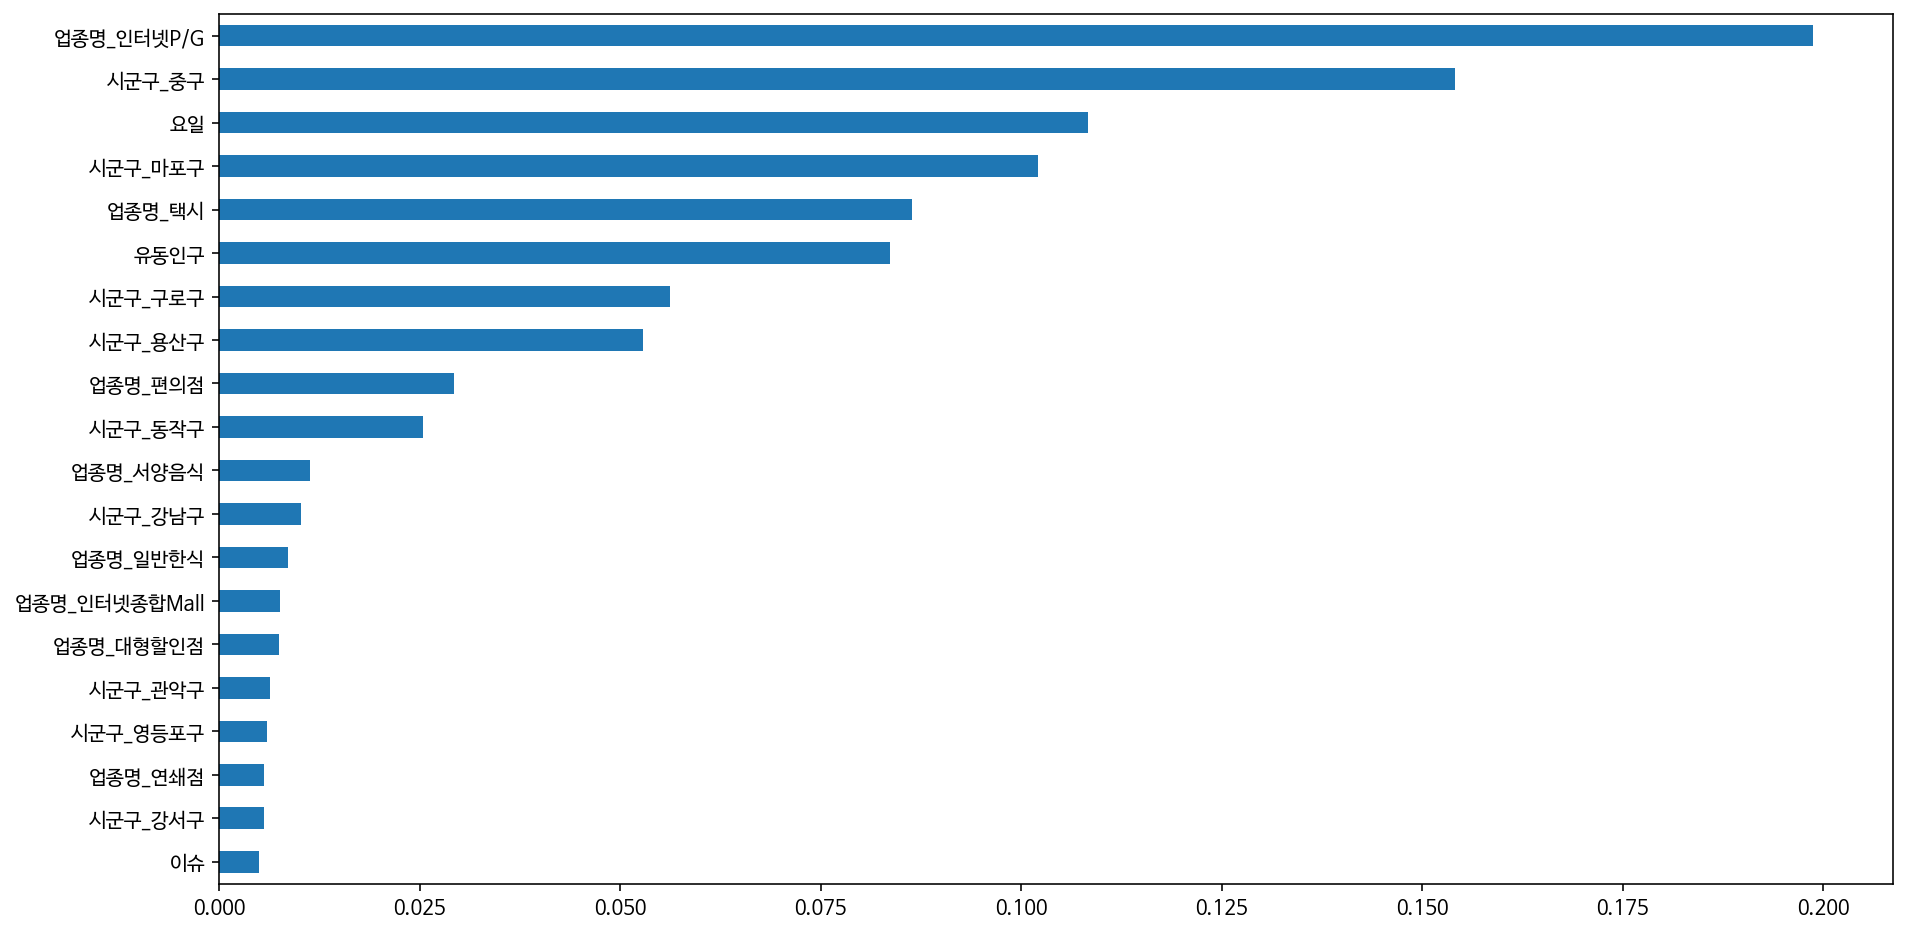

time: 492 ms


In [ ]:
feat_imp.plot.barh(figsize = (15, 8))
plt.gca().invert_yaxis()

In [ ]:
train_dummies

,유동인구,요일,이슈,업종명_1급호텔,업종명_2급호텔,업종명_CATV홈쇼핑,업종명_LPG,업종명_PG상품권,업종명_가구,업종명_가방,업종명_가전제품,업종명_가정용품수리,업종명_고속버스,업종명_골프연습장,업종명_골프용품,업종명_관광여행,업종명_국산신차,업종명_귀금속,업종명_기능학원,업종명_기타건강식,업종명_기타교육,업종명_기타교통수단,업종명_기타레져업,업종명_기타보험,업종명_기타숙박업,업종명_기타음료식품,업종명_기타의료기관및기타의료기기,업종명_기타잡화,업종명_기타전기제품,업종명_노래방,업종명_농축수산가공품,업종명_당구장,업종명_대학등록금,업종명_대형할인점,업종명_독서실,업종명_동물병원,업종명_레져업소,업종명_레져용품수리,업종명_면세점,업종명_문구용품,...,업종명_통신서비스,업종명_통신판매,업종명_특급호텔,업종명_티켓,업종명_편의점,업종명_피부미용실,업종명_학습지교육,업종명_학원(회원제형태),업종명_한약방,업종명_한의원,업종명_항공사,업종명_헬스크럽,업종명_화랑,업종명_화방표구점,업종명_화장품,시군구_강남구,시군구_강동구,시군구_강북구,시군구_강서구,시군구_관악구,시군구_광진구,시군구_구로구,시군구_금천구,시군구_노원구,시군구_도봉구,시군구_동대문구,시군구_동작구,시군구_마포구,시군구_서대문구,시군구_서초구,시군구_성동구,시군구_성북구,시군구_송파구,시군구_양천구,시군구_영등포구,시군구_용산구,시군구_은평구,시군구_종로구,시군구_중구,시군구_중랑구
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,3720047,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-27,3592992,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2020-06-10,1889115,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-14,5169595,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-24,1794224,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02,2322530,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-02,1595263,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-09,1685287,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


time: 195 ms


In [ ]:
from sklearn.model_selection import  cross_val_score,GridSearchCV
regressorCV = RandomForestRegressor(n_estimators = 10, random_state = 42)
clf_score = cross_val_score(regressorCV, train_dummies, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
print(abs(clf_score))
abs(clf_score).mean()

[5963.66230921 6251.90906212 5768.00205937 5776.20121714 7937.57610052]


6339.470149669747

time: 6min 43s


In [ ]:
from sklearn.model_selection import  cross_val_score,GridSearchCV
regressorCV = RandomForestRegressor(n_estimators = 100, max_features = 0.33, min_samples_split = 20, random_state = 42)
clf_score = cross_val_score(regressorCV, train_dummies, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
print(abs(clf_score))
abs(clf_score).mean()

[4223.61146089 6290.47085094 5119.76300279 5150.90343279 7556.8036    ]


5668.31046948036

time: 23min 41s


In [ ]:
from sklearn.model_selection import GridSearchCV

regressor = RandomForestRegressor(random_state = 42)
parameters = [{'n_estimators' : [100, 200], 'max_features' : [0.33]}]
grid_search = GridSearchCV(estimator = regressor, param_grid = parameters, cv = 5, verbose = 2)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters, best_accuracy)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] max_features=0.33, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. max_features=0.33, n_estimators=100, total= 4.9min
[CV] max_features=0.33, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s


[CV] .............. max_features=0.33, n_estimators=100, total= 4.8min
[CV] max_features=0.33, n_estimators=100 .............................
[CV] .............. max_features=0.33, n_estimators=100, total= 4.8min
[CV] max_features=0.33, n_estimators=100 .............................
[CV] .............. max_features=0.33, n_estimators=100, total= 5.0min
[CV] max_features=0.33, n_estimators=100 .............................
[CV] .............. max_features=0.33, n_estimators=100, total= 4.9min
[CV] max_features=0.33, n_estimators=200 .............................
[CV] .............. max_features=0.33, n_estimators=200, total= 9.7min
[CV] max_features=0.33, n_estimators=200 .............................
[CV] .............. max_features=0.33, n_estimators=200, total= 9.8min
[CV] max_features=0.33, n_estimators=200 .............................
[CV] .............. max_features=0.33, n_estimators=200, total= 9.7min
[CV] max_features=0.33, n_estimators=200 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 73.5min finished


{'max_features': 0.33, 'n_estimators': 100} 0.8437314491792695
time: 1h 20min 5s


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

5193.979613037679


In [ ]:
pd.Series(data = rf.feature_importances_, index = cols).sort_values(ascending = False).head(20)

시군구번호            0.546001
업종명_인터넷P/G       0.171368
요일               0.141863
업종명_택시           0.051664
업종명_편의점          0.028948
업종명_서양음식         0.011331
확진자수             0.008765
업종명_일반한식         0.008558
업종명_대형할인점        0.007966
이슈               0.007099
업종명_인터넷종합Mall    0.005962
업종명_이동통신요금       0.004959
업종명_연쇄점          0.001241
업종명_약국           0.001015
업종명_생명보험         0.000626
업종명_손해보험         0.000543
업종명_제과점          0.000518
업종명_기타음료식품       0.000213
업종명_기타레져업        0.000190
업종명_의원           0.000169
dtype: float64

time: 21.8 ms
